In [1]:
#### Paired-map for SIMPLE-seq
#### Single-cell Ppigenomics Analysis Pipeline
#### Chenxu Zhu, cxzhu@pku.edu.cn
#### 2020-04-15
version="2020.04.15"

###
{ ### External packages
	print("Checking, installing and loading packages...")
	#if (!require(Matrix)) install.packages('Matrix')
	library(Matrix)
	#if (!require(irlba)) install.packages('irlba')
	library(irlba)
	#if (!require(uwot)) install.packages('uwot')
	library(uwot)
	#if (!require(RColorBrewer)) install.packages('RColorBrewer')
	library(RColorBrewer)
	#if (!require(Rtsne)) install.packages('Rtsne')
	library(Rtsne)
	#if (!require(stats)) install.packages('stats')
	library(stats)
	#if (!require(GenomicRanges)) install.packages('GenomicRanges')
	library(GenomicRanges)
	#if (!require(igraph)) install.packages('igraph')
	library(igraph)
	#if (!require(FNN)) install.packages('FNN')
	library(FNN)	
	#if (!require(matrixcalc)) install.packages('matrixcalc')
	library(matrixcalc)	
	print("External packages loaded..")
} # end of external packages

print("Loading SIMPLE-map functions...")
{ ### Paired-map classes
	colPanel = c(
		"#E31A1C", "#FFD700", "#771122", "#777711", "#1F78B4", "#68228B", "#AAAA44",
		"#60CC52", "#771155", "#DDDD77", "#774411", "#AA7744", "#AA4455", "#117744", 
		"#000080", "#44AA77", "#AA4488", "#DDAA77", "#D9D9D9", "#BC80BD", "#FFED6F",
	    "#7FC97F", "#BEAED4", "#FDC086", "#FFFF99", "#386CB0", "#F0027F", "#BF5B17",
	    "#666666", "#1B9E77", "#D95F02", "#7570B3", "#E7298A", "#66A61E", "#E6AB02",
	    "#A6761D", "#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C", "#FB9A99", "#E31A1C",
	    "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A", "#B15928", "#FBB4AE", "#B3CDE3",
	    "#CCEBC5", "#DECBE4", "#FED9A6", "#FFFFCC", "#E5D8BD", "#FDDAEC", "#F2F2F2",
	    "#B3E2CD", "#FDCDAC", "#CBD5E8", "#F4CAE4", "#E6F5C9", "#FFF2AE", "#F1E2CC",
	    "#CCCCCC", "#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FFFF33", "#A65628",
	    "#F781BF", "#999999", "#66C2A5", "#FC8D62", "#8DA0CB", "#E78AC3", "#A6D854",
	    "#FFD92F", "#E5C494", "#B3B3B3", "#8DD3C7", "#FFFFB3", "#BEBADA", "#FB8072",
	    "#80B1D3", "#FDB462", "#B3DE69", "#FCCDE5"
  )
	{ ## distMatrix class
		methods::setClassUnion("MatrixOrmatrix", c("Matrix", "matrix"))
		distMatrix<-setClass(
			Class="distMatrix",
			slots=list(
				rmat="MatrixOrmatrix",
				nmat="MatrixOrmatrix",
				norm="logical",
				method="character",
				p1="numeric",
				p2="numeric"
			)
		)
		setMethod(
			f='show',
			signature='distMatrix',
			definition=function(object){
				cat(
					"# of cells: ", nrow(object@rmat),"\n",
					"# of dims: ", ncol(object@rmat), "\n",
					"Normalized: ", object@norm, "\n",
					"Method: ", object@method, "\n"
				)
			}
		)
		newDistMatrix<-function(){
			res=new("distMatrix",
				rmat=matrix(0,0,0),
				nmat=matrix(0,0,0),
				p1=numeric(),
				p2=numeric(),
				norm=FALSE,
				method=""
			)
		}
	} 
	{ ## dimReduction class
		dimReduction<-setClass(
			Class="dimReduction",
			slots=list(
				dmat="matrix",
				sdev="numeric",
				iter="numeric",
				method="character"
				)
			)
		setMethod(
			f="show",signature="dimReduction",
			definition=function(object){
				cat(
					"# of dims:", ncol(x=object@dmat), "Method: ", object@method, "\n",
					)}
			)
		newDimReduction<-function(object){
			res=new("dimReduction",
				dmat=matrix(0,0,0),
				sdev=numeric(),
				method=character(),
				iter=numeric()
				)
		}
	} # end of dimReduction class

	{ ## dataMatrix class
		methods::setClassUnion("MatrixOrmatrix", c("Matrix", "matrix"))
		dataMatrix<-setClass(
			Class="dataMatrix",
			slots=list(
				mat="MatrixOrmatrix",
				bins="character"
			)
		)
		setMethod(
			f="show",signature="dataMatrix",
			definition=function(object){
				cat(
					"# of cells:", ncol(x=object@mat), "\n",
					"# of bins:", nrow(x=object@mat), "\n",
					sep=""
				)
			}
		)
		newDataMatrix<-function(){
			mat=matrix(0,0,0)
			bins=as.character(c())
		}
	} # end of dataMatrix class

	{ ## embedding class
		methods::setClassUnion("MatrixOrmatrix", c("Matrix", "matrix"))
		embedding<-setClass(
			Class="embedding",
			slots=list(
				vis="MatrixOrmatrix",
				method="character"
			)
		)
		setMethod(
			f="show",signature="embedding",
			definition=function(object){
				cat(
					"Method: ", object@method, "\n"
				)
			}
		)
		newEmbedding<-function(){
			vis=matrix(nrow=0,ncol=0)
			method=character()
		}
	} # end of embedding class

	{ ## cluster class 
		cluster<-setClass(
			Class="cluster",
			slots=list(
				id="numeric",
				method="character"
			)
		)
		setMethod(
			f="show",signature="cluster",
			definition=function(object){
				NULL ### need to be filled
			}
		)
		newCluster<-function(){
			id=numeric()
		}

	} # end of cluster class	

	{ ## paired class
		methods::setClassUnion("MatrixOrmatrix", c("Matrix", "matrix"))
		paired<-setClass(
			Class="paired",
			slots=list(
				project="character",	## project name
				barcode="character",	## cell id
				mat.filt="dataMatrix",## filtered data matrix	
				mat.raw="dataMatrix",	## joint data matrix	
				mat.nor="dataMatrix", ## normalized data matrix
				dis="distMatrix",			## Distance matrix 
				pca="dimReduction",		## dimension reduction
				tsne="embedding",			## cell embeddings
				umap="embedding",			## cell embeddings
				cluster="cluster",
				cell.downsample="numeric"
				)
			)
		setMethod("show", signature = "paired",
			definition=function(object){
				if((x=length(object@project))>=0L){
					cat("Paired-seq/tag dataset: ", object@project, "\n")
					#cat("# of cells: ", ifelse(is.null(length(object@barcode), 0, length(object@barcode))), "\n")
					cat("# of cells: ", length(object@barcode), "\n", sep="")
					cat("==Raw matrices==\n")
					cat("# of bins: ", nrow(object@mat.raw@mat), "\n", sep="")
					cat("==Filtered matrices==\n")
					cat("# of bins: ", nrow(object@mat.filt@mat), "\n", sep="")
					cat("==Normalized matrices==\n")
					cat("# of bins: ", nrow(object@mat.nor@mat), "\n", sep="")
				}
			}
		)
	} # end of paired class
} ### end of Paired-map classes


{ ### Paired-map functions 
	{ ## newPaired 
		methods::setClassUnion("MatrixOrmatrix", c("Matrix", "matrix"))
		newPaired=function(){
			project=character()
			barcode=as.character(c())
			mat.filt=dataMatrix()
			mat.raw=dataMatrix()
			mat.nor=dataMatrix()
			dis=distMatrix()
			pca=dimReduction()
			tsne=embedding()
			umap=embedding()
			cluster=cluster()
			cell.downsample=as.numeric(c())
			res=new("paired",
			        project=project,
			        barcode=barcode,
			        mat.filt=mat.filt,
			        mat.raw=mat.raw,
			        mat.nor=mat.nor,
			        dis=dis,
			        pca=pca,
			        tsne=tsne,
			        umap=umap,
			        cluster=cluster,
			        cell.downsample=cell.downsample
			        )
		}
	} # 
	{## loadDataSet
		loadDataSet<-function(dna,  min.features, min.cells, project){
			UseMethod("loadDataSet")
		}
		loadDataSet.default<-function(dna,  min.features, min.cells, project){
			if(missing(dna)){stop("Path to matrix is missing...")}
			if(missing(project)){project="Default Project"}
			if(missing(min.features)){min.features=200} # min fragments per nuclei 200
			if(missing(min.cells)){min.cells=3} # min cells per fragment 3
			print("Loading matrix...")
			obj=newPaired()

			## Loading DNA matrix
			dna_mat=readMM(paste(dna, "matrix.mtx", sep="/"))
			dna_bc=read.csv(paste(dna,"barcodes.tsv", sep="/"), head=F)
			dna_peaks=read.csv(paste(dna, "bins.tsv", sep="/"), head=F)
			colnames(dna_mat)<-dna_bc[,1]
			rownames(dna_mat)<-dna_peaks[,1]
			rm(dna_bc)
			rm(dna_peaks)
			## report DNA matrix ststs
			print("Loaded DNA matrix")
			cat("# of barcodes: ", ncol(dna_mat), "\n", "# of bins: ", nrow(dna_mat), "\n")
			## pre filt DNA matrix
			dna_mat.b<-dna_mat
			dna_mat.b@x[dna_mat.b@x>1]<-1
			n_fragments<-colSums(dna_mat.b)
			dna_mat_filt<-dna_mat[,n_fragments>min.features]
			rm(dna_mat)
			dna_bins<-dna_mat_filt
			dna_bins@x[dna_bins@x>0]<-1
			n_cell_dna<-rowSums(dna_bins)
			rm(dna_bins)
			dna_mat_filt<-dna_mat_filt[n_cell_dna>min.cells,]
			cat("Min # of fragments: ", min.features, "\n\n",sep="")
			obj@mat.raw@bins=rownames(dna_mat_filt)
			obj@mat.raw@mat=dna_mat_filt
			obj@barcode=colnames(dna_mat_filt)
			obj@project=project
			mat<-obj@mat.raw@mat
			mat@x[mat@x>0]<-1
			s<-colSums(mat)
			cat("# of PF barcodes: ", ncol(dna_mat_filt), "\n", "# of PF bins: ", nrow(dna_mat_filt), "\n", "Median usable features: ", median(s),"\n\n",sep="")
			return(obj)
		}

		logMean<-function(input){
			input.b<-input
			input.b@x[input.b@x>0]<-1
			mat.colsum<-colSums(input.b)
			mean.colsum<-mean(mat.colsum)
			scale.factor<-mat.colsum/mean.colsum
			mat.nor<-t(input)/scale.factor
			mat.nor<-log(mat.nor+1)
			mat.nor<-t(mat.nor)
			return(mat.nor)
		}

		logMedian<-function(input){
			input.b<-input
			input.b@x[input.b@x>0]<-1
			mat.colsum<-colSums(input.b)
			mean.colsum<-median(mat.colsum)
			scale.factor<-mat.colsum/mean.colsum
			mat.nor<-t(input)/scale.factor
			mat.nor<-log(mat.nor+1)
			mat.nor<-t(mat.nor)
			return(mat.nor)
		}

		filtMatrix<-function(obj, high.threshold, low.threshold, method){
			UseMethod("filtMatrix", obj)
		}
		filtMatrix.default<-function(obj, high.threshold=5, low.threshold=-5, method){
			if(missing(obj)){stop("No Paired-seq dataset available...")}
			if(missing(method)){stop("Please specify a method: binary/logMean/logMedian")}

			raw_mat<-obj@mat.raw@mat;features<-obj@mat.raw@bins
			tmp_mat<-raw_mat
			tmp_mat@x[tmp_mat@x>0]<-1
			nCell_bin<-rowSums(tmp_mat)
			rm(tmp_mat)
			log_nCell_bin=log10(nCell_bin+1)
			s_log_nCell_bin=scale(log_nCell_bin)
			par(mar=c(2.5,3.5,3.5,2), lab=c(10,5,5))
			hist(s_log_nCell_bin, breaks=100, xlim=c(-5,5), col="grey", main="", xlab="Scale Features", tcl=-.25)
			val_bin<- c((s_log_nCell_bin>low.threshold)&(s_log_nCell_bin<high.threshold))
			filt_mat<-raw_mat[val_bin,]; filt_features<-features[val_bin]
			print("Filter features")
			cat("# total features: ", nrow(raw_mat), "\n", "# filtered features: ", nrow(filt_mat), "\n", sep="")
			cat("Normalizing...", " Method: ", method, "\n", sep="")
			if(method=="binary"){
				nor_mat<-filt_mat
				nor_mat@x[nor_mat@x>0]<-1
			}
			else if(method=="logMean"){
				nor_mat<-logMean(filt_mat)
			}else if(method=="none"){
				nor_mat<-as.matrix(filt_mat)
			}else if(method=="logMedian"){
				nor_mat<-logMedian(filt_mat)
			}
			else{stop("Please specify a method: binary/logMean")}
			obj@mat.filt@mat<-filt_mat
			obj@mat.nor@mat<-nor_mat
			obj@mat.filt@bins<-filt_features
			obj@mat.nor@bins<-filt_features
			rm(raw_mat)
			rm(filt_mat)
			rm(filt_features)
			return(obj)
		}

		calEuclidean<-function(mat.use){
			mat.use<-t(mat.use)
			smat<-apply(mat.use, 1, crossprod)
			mat1<-matrix(smat, nrow=dim(mat.use)[1], ncol=dim(mat.use)[1])
			mat3<-tcrossprod(mat.use)
			mat4<-mat1+t(mat1)-2*mat3
			diag(mat4)<-0
			mat5<-sqrt(mat4)
			mat5<-scale(mat5)
			return(mat5)
		}

		runDistance<-function(obj, feature.downsample, cell.downsample, seed.use, method){
			UseMethod("runDistance", obj)
		}
		runDistance.default<-function(obj, feature.downsample=1, cell.downsample=1, seed.use=131, method){
			if(missing(obj)){stop("No input object...")}
			 if(missing(method)){stop("Please. specify a method... pearson/euclidean")}
			#method="euclidean"
			if(length(obj@cell.downsample)>10L){
				cell.use<-obj@cell.downsample
				cat("Cell downsampling existed.\nUsing pre-defined cell subsampling...\n")
				not_new=1
			}
			else{
				if(cell.downsample>1 || cell.downsample<0){cell.downsample=1}
				if(cell.downsample==1){
					cell.use=c(1:length(obj@barcode))
				}
				else{
					cell.use.size=as.integer(length(obj@barcode)*cell.downsample)
					#cell.use<-c(rep(TRUE, cell.use.size), rep(FALSE, length(obj@barcode)-cell.use.size))
					set.seed(seed.use)
					cell.use=sample(length(obj@barcode), cell.use.size)
					#cell.use<-cell.use[sample(length(obj@barcode))]
					obj@cell.downsample=cell.use
				}
				not_new=0
			}
			if(feature.downsample>1 || feature.downsample<0){feature.downsample=1}
			if(dim(obj@mat.nor@mat)[1]<1L){
				stop("Matrix not normalized.")
			}
			mat.input=obj@mat.nor@mat
			mat.use<-mat.input
			if(feature.downsample == 1){
				mat.ref<-mat.use[,cell.use]
			}
			else{
				umi.mat.ref<-rowSums(mat.ref)
				feature.use.size=as.integer(feature.downsample*dim(mat.input)[1])
				if(length(umi.mat.ref[umi.mat.ref>0])<feature.ref.size){
					cat("Too few features with non-zero sum. Using all non-zero features.\n")
					feature.use.size=length(umi.mat.use[umi.mat.use>0])
				}
				feature.order.pool<-rev(order(umi.mat.ref))[1:feature.use.size]
				set.seed(seed.use)
				feature.use<-sample(feature.order.pool, feature.use.size)
				mat.use<-mat.input[feature.use,]
				mat.ref<-mat.input[feature.use,cell.use]
			}
			## check
			if(method=="euclidean"){
				cat("Calulating Euclidean Matrix...\n")
				jmat<-calEuclidean(mat.use)
				jmat<-jmat[cell.use,]
				jmat<-as.matrix(jmat)
			}
			else if(method=="pearson"){
				cat("Calculating pearson's correlation...\n")
				jmat<-cor(log(mat.use+1))
				#jmat<-cor((mat.use))
				jmat<-jmat[cell.use,]
				jmat<-as.matrix(jmat)
			}
			else{
				stop("No method supported")
			}
			if(1){
				p1=Matrix::colMeans(mat.use)
				p2=p1[cell.use]
				obj@dis@p1=p1
				obj@dis@p2=p2				
			}
			# obj@dis@rmat<-jmat
			obj@dis@method=method
			obj@dis@nmat<-jmat
			rm(jmat)
			rm(mat.use)
			rm(mat.ref)
			return(obj)
		}
	} # end of calJaccard
	{ ## pca
		runPCA<-function(obj,n){
			UseMethod("runPCA")
		}
		runPCA.default<-function(obj,n=50){
			if(missing(obj)){stop("Are you kidding me?")}
			mat<-obj@dis@nmat
			pca<-prcomp_irlba(t(mat), n=n)
			obj@pca@dmat<-pca$x
			obj@pca@sdev<-pca$sdev
			obj@pca@iter<-0
			obj@pca@method<-"PCA"
			return(obj)
		}
	}

	{ ## runVIS
		runVis<-function(obj,k, use.dims, method,...){
			UseMethod("runVis")
		}
		runVis.default<-function(obj,  k=15, use.dims=c(1,10),method,...){
			if(missing(obj)){stop("Are you kidding me?")}
			if(missing(method)){method="UMAP"}
			mat<-obj@pca@dmat[,use.dims]
			if(method=="UMAP"){
				vis.out<-umap(mat, n_neighbors=k, verbose=T, n_threads=8, ...)
				obj@umap@vis<-vis.out
			}
			if(method=="tSNE"){
				tsne.out<-Rtsne(mat, n_neighbors=k, pca=FALSE, verbose=T, num_threads=8, max_iter=iter, ...)
				obj@tsne@vis<-tsne.out$Y
			}
			return(obj)
		}
	} # end of runVIS
		
	{ ## cluster
		runCluster<-function(obj,seed.use,use.dims,k,...){
			UseMethod("runCluster", obj)
		}
		runCluster.default<-function(obj,seed.use=131,use.dims=c(1,10),k=15,...){
			if(missing(obj)){stop("No object...\n")}
			mat<-obj@pca@dmat[,use.dims]
			knn.norm=get.knn(as.matrix(mat), k=k)
			knn.norm = data.frame(from = rep(1:nrow(knn.norm$nn.index),  k), to = as.vector(knn.norm$nn.index), weight = 1/(1 + as.vector(knn.norm$nn.dist)))
			nw.norm = graph_from_data_frame(knn.norm, directed = FALSE)
			nw.norm = simplify(nw.norm)
			lc.norm.combine = cluster_louvain(nw.norm)
			obj@cluster@id<-lc.norm.combine$membership
			return(obj)
		}
	} # end of cluster
	
	col.geneExpr<-colorRampPalette(c("gray85", "forestgreen", "darkgreen"))(10)
	col.promAccs<-colorRampPalette(c("gray85", "deepskyblue3", "deepskyblue4"))(10)
	col.depth<-colorRampPalette(c("grey85", "salmon1", "salmon4"))(10)
	
	t_col <- function(color, percent = 50, name = NULL) {
		rgb.val <- col2rgb(color)
		t.col <- rgb(rgb.val[1,], rgb.val[2,], rgb.val[3,],
             max = 255,
             alpha = (100 - percent) * 255 / 100,
             names = name)
		return(t.col)
	}

	minMaxScaling_non_zero<-function(x){
		return((x+0.001-min(x))/(max(x)+0.001-min(x)))
	}

	minMaxScaling<-function(x){
		return((x-min(x))/(max(x)-min(x)))
	}

	{ ## plotFeature

		plotDepth<-function(obj){
			mat<-obj@mat.raw@mat
			mat@x[mat@x>0]<-1
			s<-colSums(mat)
			par(mar=c(2.5, 2.5, 2.5, 2.5))
			par(mfrow=c(1,1))
			plot(rev(sort(s)), pch=19, col="grey", cex=0.5, log="xy", xlab="# of BCs", ylab="# of features")
			median<-median(s)
			ncell<-dim(mat)[2]
			lines(c(1,ncell), c(median, median), lwd=2, lty=2, col="grey")
			legend("bottomleft", legend=c(paste("# of Cells: ", ncell, sep=""), paste("Median # of features: ", median, sep="")), bty="n")
		}
		
		plotFeature<-function(obj, feature, norm.frac, norm.log,embedding.use, outlies, title,pch,cex, legend,legend.position,...){
			UseMethod("plotFeature", obj)
		}
		plotFeature.default<-function(obj, feature, norm.frac=FALSE, norm.log=FALSE, outliers=c(0.01,0.99),embedding.use="umap",pch=19, cex=0.25, title,legend.position="right",legend=F,...){
			if(missing(obj)){stop("Please specify an object..\n")}
			if(missing(feature)){stop("Please specify an feature...\n")}
			if(feature=="cluster"){
				feature.value=obj@cluster@id
				col=colPanel
				legend=T
			}else	if(feature=="depth"){
				m.b<-obj@mat.raw@mat
				m.b@x[m.b@x>0]<-1
				feature.value=colSums(m.b)
				feature.value=log(feature.value+1)
				col<-col.depth
				feature.value<-minMaxScaling(feature.value)*9+1
			}else if(feature=="barcode"){
				barcodes<-obj@barcode
				# bc.split<-as.integer(strsplit(barcodes,":")[[1]])
				write.table(barcodes, file="bc.tmp", quote=F, col.names=F, row.names=F)
				bc.split<-read.csv("bc.tmp", sep=":", head=F)
				feature.value<-bc.split[,dim(bc.split)[2]]
				col<-colorRampPalette(c("red","grey", "blue"))(12)
				legend=T
			}
			else{
				### plot gene expression or promoter accessibility
				idx=which(obj@mat.raw@bins==feature)
				if(length(idx)==0){stop("Cannot find ", feature, "\n", sep="")}
				feature.value=obj@mat.raw@mat[idx,]

				if(norm.frac){
					cell.size<-colSums(obj@mat.raw@mat)
					feature.value<-feature.value/cell.size
				}
				## log normalize
				if(norm.log){
					feature.value=log(feature.value+1)
				}
								## filter outliers
				outlier.low=quantile(feature.value, outliers[1])
				outlier.high=quantile(feature.value, outliers[2])
				feature.value[feature.value>outlier.high]=outlier.high
				feature.value[feature.value<outlier.low]=outlier.low
				feature.value<-minMaxScaling(feature.value)*9+1
			}
			if(missing(title)){title=paste(feature, "on", toupper(embedding.use), sep=" ")}
			if(tolower(embedding.use)=="umap"){mat=obj@umap@vis;labx="UMAP1";laby="UMAP2"}
			if(tolower(embedding.use)=="tsne"){mat=obj@tsne@vis;labx="tSNE1";laby="tSNE2"}
			if(tolower(embedding.use)=="pca"){mat=obj@pca@dmat[,1:2];labx="PC1";laby="PC2"}
			ncol=0
			if(legend){ncol=as.integer(max(feature.value/20)+1)} 
			par(mar=c(2.5, 2.5, 3, 3.0+1.20*ncol),xpd=TRUE, col.axis="black", cex.axis=1, lab=c(3,3,5), mgp=c(1.25,0.25,0))
			plot(mat, pch=pch,cex=cex,col=col[feature.value], main=title,xlab=labx, ylab=laby, bty="l", tcl=-.25, xgap.axis=2, ygap.axis=2, font.lab=2, ...)
			if(legend){legend("right", inset=c(-0.12,0),legend=c(1:max(feature.value)), pch=19, cex=0.75, ncol=ncol, bty="n", col=col)}
		}

		plotPCA<-function(obj){
			UseMethod("plotPCA", obj)
		}
		plotPCA.default<-function(obj){
			#opar<-par(newsettings)
			par(mar=c(2.5,3.5,3.5,2), lab=c(10,5,5))
			if(missing(obj)){stop("Please specify an object..")}
			layout(matrix(c(1,1,2,3,4,1,1,5,6,7,8,9,10,11,12,13,14,15,16,17),4,5,byrow=TRUE))
			pca<-obj@pca@dmat;sdev<-obj@pca@sdev
			plot(sdev, pch=19, col="grey", cex=0.5, xlab="PC", ylab="sdev", main=paste("PCA sdev", sep=" "), tcl=-.25)
			barcodes<-obj@barcode
			write.table(barcodes, file="bc.tmp", quote=F, col.names=F, row.names=F)
			bc.split<-read.csv("bc.tmp", sep=":", head=F)
			feature.value<-bc.split[,dim(bc.split)[2]]
			col<-colorRampPalette(c("red","grey", "blue"))(12)
			for(i in 1:16){
				pc1<-i*2-1;pc2<-i*2
				plot(pca[,pc1:pc2], pch=19, cex=0.05, col=colPanel[feature.value], tcl=-.25, main=paste("PC", pc1, " vs PC", pc2, sep=""))
			}
			par(mfrow=c(1,1))
		}
	} # end of plotFeature
}# end of Paired-map functions

print("Finished loading SIMPLE-map functions...")
print(paste("Version: ", version, sep=""))


[1] "Checking, installing and loading packages..."


Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:Matrix’:

    expand, unname


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loa

[1] "External packages loaded.."
[1] "Loading SIMPLE-map functions..."
[1] "Finished loading SIMPLE-map functions..."
[1] "Version: 2020.04.15"


In [2]:
mtx<-"mESC_5hmC_merged_CPG_1_blk"
obj<-loadDataSet(dna=mtx,
                  project="SIMPLE_seq",
                  min.features=0,
                  min.cells=0)


[1] "Loading matrix..."
[1] "Loaded DNA matrix"
# of barcodes:  1095 
 # of bins:  26602 
Min # of fragments: 0

# of PF barcodes: 1095
# of PF bins: 26588
Median usable features: 4287



[1] "Filter features"
# total features: 26588
# filtered features: 25650
Normalizing... Method: none
Calulating Euclidean Matrix...


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3886076,207.6,5816808,310.7,5816808,310.7
Vcells,129112749,985.1,256727940,1958.7,256727398,1958.7


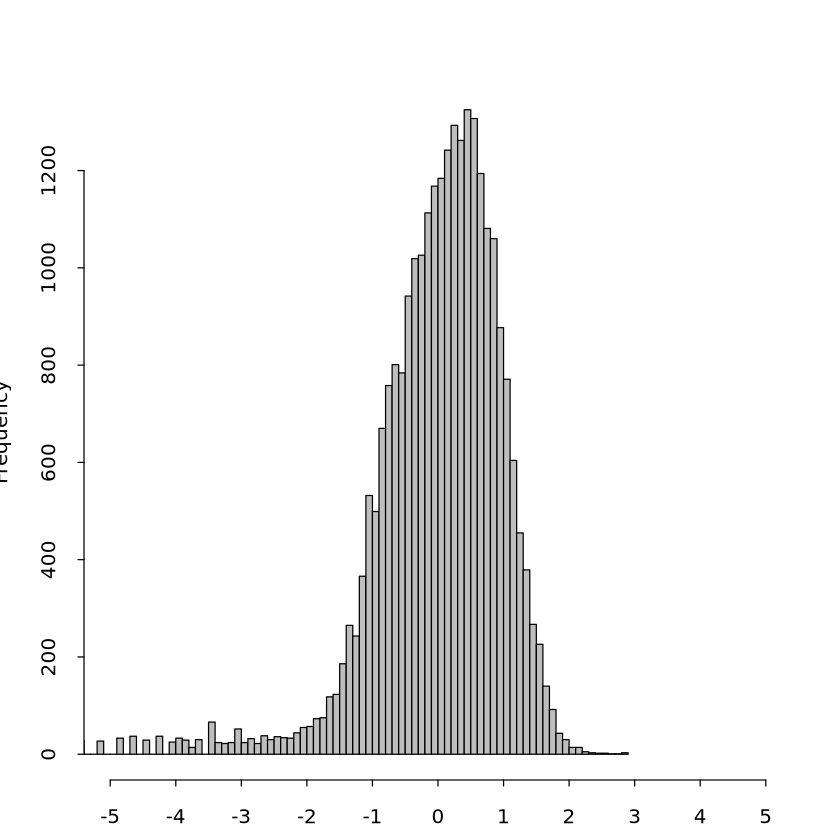

In [3]:
bc.split=matrix(as.integer(unlist(strsplit(as.vector(obj@barcode),split=":"))),ncol=3, byrow=T)
obj<-filtMatrix(obj, low.threshold=-2, high.threshold = 2, method="none")
obj<-runDistance(obj, cell.downsample = 1, feature.downsample = 1, method="euclidean");gc()
obj<-runPCA(obj)



22:27:20 UMAP embedding parameters a = 1.577 b = 0.8951

22:27:20 Read 1095 rows and found 50 numeric columns

22:27:20 Using Annoy for neighbor search, n_neighbors = 50



22:27:21 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:27:21 Writing NN index file to temp file /scratch/RtmpGk5sBv/filec34b46db9fb0a

22:27:21 Searching Annoy index using 8 threads, search_k = 5000

22:27:21 Annoy recall = 100%

22:27:21 Commencing smooth kNN distance calibration using 8 threads
 with target n_neighbors = 50

22:27:22 Initializing from normalized Laplacian + noise (using irlba)

22:27:22 Commencing optimization for 500 epochs, with 85956 positive edges

22:27:22 Using rng type: pcg

22:27:24 Optimization finished



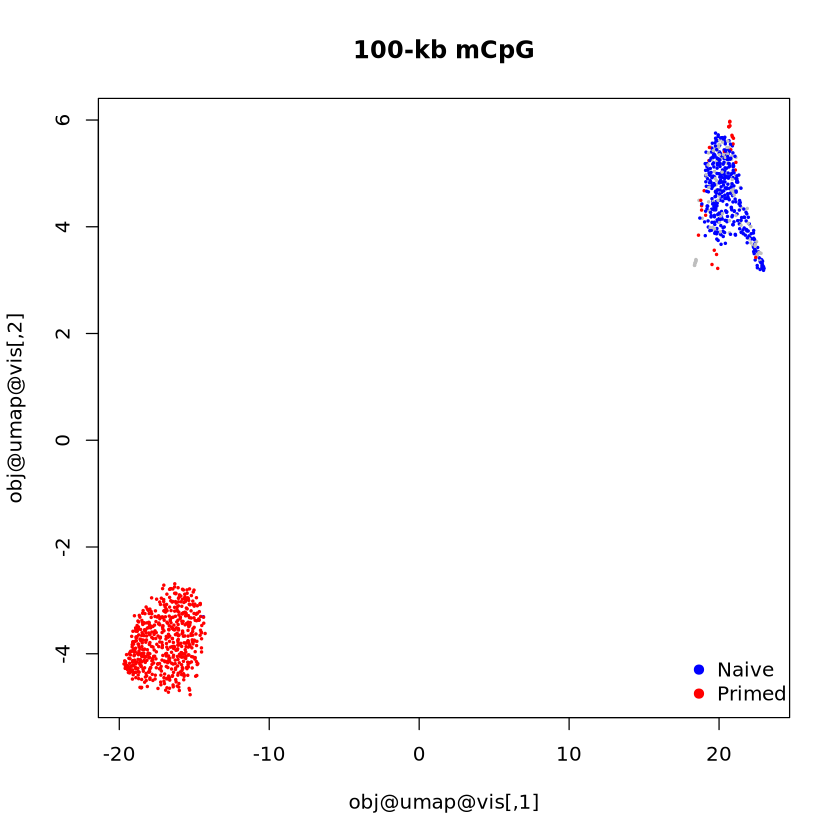

In [4]:
pc1=1;pc2=50;pc.use=c(pc1:pc2);k=50
    #pc.use=c(3:26,26,26)
obj<-runVis(obj, use.dims=pc.use, k=k, method="UMAP", metric = "cosine", min_dist = 0.1)
col<-c("grey", "blue", "blue", "blue", "blue", "blue", "red", "red", "red", "red", "red", "red")
plot(obj@umap@vis, pch=19, col=col[bc.split[,3]], cex=0.25, main="100-kb mCpG");legend("bottomright", legend=c("Naive", "Primed"), pch=19, col=c("blue", "red"), bty="n")
